### **What Is Transfer Learning ?**
If not for Transfer Learning, Machine Learning is a pretty tough thing to do for an absolute beginner. At the lowest level, machine learning involves computing a function that maps some inputs to their corresponding outputs. Though the function itself is just a bunch of addition and multiplication operations, when passed through a non linear activation function and stacking a bunch of these layers together, functions can be made, to learn literally anything, Provided there’s enough data to learn from, and an enormous amount of computational power.

### *Welcome to Deep Learning.*

Convolutional Neural Networks can learn extremely complex mapping functions when trained on enough data. We can’t yet understand how a convolutional net learns such complicated functions.

At a base level, the weights of a CNN (Convolutional Neural Network) consist of **filters**. Think of a filter as an (**n*n**) matrix which consists of certain numbers. Now this filter is **convoluted(slide and multiply)** through the provided image. Assume the input image is of size (10,10) and the filter is of size (3,3), first the filter is multiplied with the 9 pixels on the top-left of the input image, this multiplication produces another (3,3) matrix. The values of the 9 pixels of this matrix are summed up and this value becomes a single pixel value on the top-left of **layer_2** of the CNN.

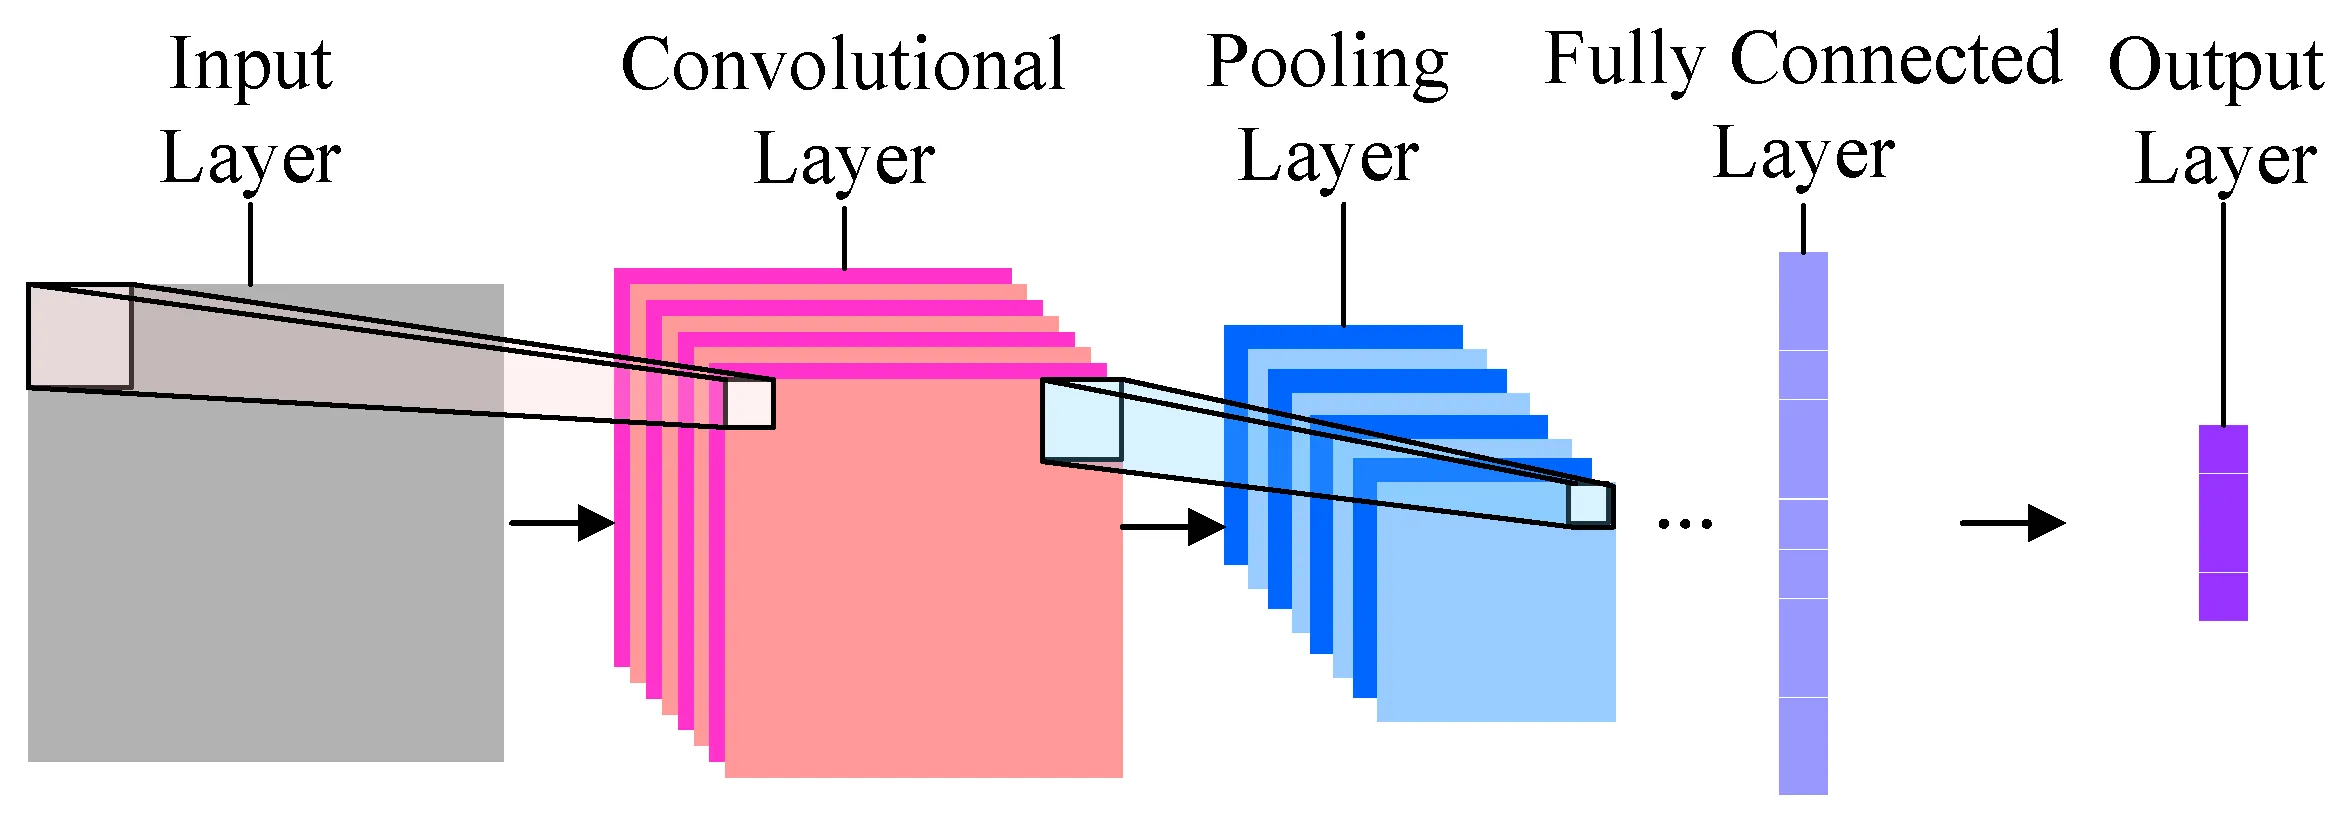

**Basically the training of a CNN involves, finding of the right values on each of the filters so that an input image when passed through the multiple layers, activates certain neurons of the last layer so as to predict the correct class.**

Though training a CNN from scratch is possible for small projects, most applications require the training of very large CNN’s and this as you guessed, takes extremely huge amounts of processed data and computational power. And both of these are not found so easily these days.

**That’s where transfer learning comes into play.** In transfer learning, we take the pre-trained weights of an already trained model(one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days) and use these already learned features to predict new classes.

> ***The advantages of transfer learning are that:***

> *   ***1: There is no need of an extremely large training dataset.***
> *   ***2: Not much computational power is required.As we are using pre-trained weights and only have to learn the weights of the last few layers.***

There are several models that have been trained on the image net dataset and have been open sourced.

For example, VGG-16, VGG-19, Inception-V3 etc. For more details about each of these models, read the official keras documentation [here](https://keras.io/api/applications/).

Some popular backbones for computer vision (CV) problems currently are:

*   ResNet (Residual Network)
*   DenseNet
*   EfficientNet

Respectively, some popular backbones for natural language processing (NLP) problems are:

*   BERT (Bidirectional Encoder Representations from Transformers)
*   RoBERTa (Robustly Optimized BERT Pretraining Approach)
*   DeBERTa (Decoding-enhanced BERT with disentangled attention)


Other great models from facebook research projects that can be used and adapted to your needs:
- https://github.com/facebookresearch

Of course, Transfer Learning is only possible due to researchers sharing their model checkpoints for the benefit of others

In [1]:
!pip install scikit-learn matplotlib tensorflow numpy


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
! pip install Bio

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [3]:
# Write a toy protein PDB file
with open("protein_dummy.pdb", "w") as f:
    f.write("""\
ATOM      1  CA  ALA A   1       5.000   5.000   5.000  1.00  0.00           C
ATOM      2  CA  GLY A   2       7.000   5.000   5.000  1.00  0.00           C
ATOM      3  CA  SER A   3       6.000   7.000   5.000  1.00  0.00           C
ATOM      4  CA  THR A   4       5.000   6.000   7.000  1.00  0.00           C
END
""")

# Write a toy pocket PDB file (subset of protein)
with open("pocket_dummy.pdb", "w") as f:
    f.write("""\
ATOM      1  CA  ALA A   1       5.000   5.000   5.000  1.00  0.00           C
END
""")


✅ Step 1: Voxelization of the Protein

🎯 Goal:
Convert the 3D coordinates of protein atoms into a 3D grid (e.g., 32×32×32) with multiple channels, like:

Atom type (C, N, O, S, etc.)

Charge

Hydrophobicity

Optional: electrostatics, B-factor, etc.

### Load the necessary libraries

The following code imports the packages needed for this example.

In [4]:
!pip install tensorflow==2.15.0


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
!pip install tensorflow==2.15


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

print('Check GPU runtime type... ')
if len(tf.config.list_physical_devices('GPU')) == 0:
  print('Change Runtype Type in top menu for GPU acceleration')
  print(' "Runtime" -> "Change Runtime Type" -> "GPU"')
else:
  print('OK!')

2025-04-17 11:50:05.237186: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-17 11:50:05.446595: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-17 11:50:05.446630: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-17 11:50:05.482763: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-17 11:50:05.556606: I tensorflow/core/platform/cpu_feature_guar

Check GPU runtime type... 
Change Runtype Type in top menu for GPU acceleration
 "Runtime" -> "Change Runtime Type" -> "GPU"


2025-04-17 11:50:08.741110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-17 11:50:08.862174: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [7]:
import numpy as np
from Bio.PDB import PDBParser

GRID_SIZE = 32
VOXEL_SIZE = 1.0  # in Å
CHANNELS = ['C', 'N', 'O', 'S']  # atom types you care about

def initialize_grid():
    return np.zeros((len(CHANNELS), GRID_SIZE, GRID_SIZE, GRID_SIZE), dtype=np.float32)

def atom_to_voxel(coord, origin, voxel_size):
    return tuple(((coord - origin) / voxel_size).astype(int))

In [8]:
import torch.nn as nn

class Pocket3DCNN(nn.Module):
    def __init__(self, in_channels=4):  # 4 = atom types: C, N, O, S
        super(Pocket3DCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),

            nn.Conv3d(128, 1, kernel_size=1),  # 1 output channel = binary classification
            nn.Sigmoid()  # voxel-wise output
        )

    def forward(self, x):
        return self.model(x)  # output shape: (batch, 1, D, H, W)

In [9]:
import numpy as np
from Bio.PDB import PDBParser

def voxelize_structure(pdb_path, origin=None, grid_size=32, voxel_size=1.0, channels=['C', 'N', 'O', 'S'], return_origin=False):
    """
    Converts a protein PDB file into a 3D voxel grid.

    Parameters:
        pdb_path (str): Path to the protein PDB file.
        origin (np.array or None): If None, automatically center the grid around the structure.
        grid_size (int): Number of voxels along each axis.
        voxel_size (float): Size of each voxel in Å.
        channels (list): Atom types to consider (default: C, N, O, S).
        return_origin (bool): If True, also return the grid origin used.

    Returns:
        grid (np.array): 4D array of shape (channels, D, H, W)
        origin (np.array): [Only if return_origin=True] The origin used to align the grid.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_path)

    if origin is None:
        coords = np.array([atom.coord for atom in structure.get_atoms()])
        origin = coords.mean(axis=0) - (grid_size * voxel_size / 2)

    grid = np.zeros((len(channels), grid_size, grid_size, grid_size), dtype=np.float32)

    for atom in structure.get_atoms():
        atom_type = atom.element.strip()
        if atom_type not in channels:
            continue
        idx = channels.index(atom_type)
        coord = np.array(atom.coord)
        voxel = ((coord - origin) / voxel_size).astype(int)
        if all(0 <= v < grid_size for v in voxel):
            grid[idx, voxel[0], voxel[1], voxel[2]] += 1

    return (grid, origin) if return_origin else grid


In [10]:
def generate_label_grid(pocket_pdb_path, origin, grid_size=32, voxel_size=1.0):
    from Bio.PDB import PDBParser
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_pdb_path)
    label_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)

    for atom in structure.get_atoms():
        coord = np.array(atom.coord)
        voxel = ((coord - origin) / voxel_size).astype(int)
        if all(0 <= v < grid_size for v in voxel):
            label_grid[voxel[0], voxel[1], voxel[2]] = 1

    return label_grid


In [11]:
import torch
from torch.utils.data import Dataset
import numpy as np

class PocketGridDataset(Dataset):
    def __init__(self, protein_paths, pocket_paths, grid_size=32, voxel_size=1.0):
        self.protein_paths = protein_paths
        self.pocket_paths = pocket_paths
        self.grid_size = grid_size
        self.voxel_size = voxel_size

    def __len__(self):
        return len(self.protein_paths)

    def __getitem__(self, idx):
        protein_pdb = self.protein_paths[idx]
        pocket_pdb = self.pocket_paths[idx]

        protein_grid, origin = voxelize_structure(protein_pdb, return_origin=True,
                                                  grid_size=self.grid_size,
                                                  voxel_size=self.voxel_size)
        label_grid = generate_label_grid(pocket_pdb, origin,
                                         grid_size=self.grid_size,
                                         voxel_size=self.voxel_size)

        # Convert to tensors
        X = torch.tensor(protein_grid, dtype=torch.float32)
        Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0)

        return X, Y


In [12]:
# List of example file paths — one protein and its pocket
protein_paths = ["protein_dummy.pdb"]
pocket_paths = ["pocket_dummy.pdb"]


In [13]:
from torch.utils.data import DataLoader
'''
model = Pocket3DCNN(in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

dataset = PocketGridDataset(protein_paths, pocket_paths)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

for epoch in range(10):
    model.train()
    for X, Y in loader:
        pred = model(X)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
'''

'\nmodel = Pocket3DCNN(in_channels=4)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\ncriterion = nn.BCELoss()\n\ndataset = PocketGridDataset(protein_paths, pocket_paths)\nloader = DataLoader(dataset, batch_size=2, shuffle=True)\n\nfor epoch in range(10):\n    model.train()\n    for X, Y in loader:\n        pred = model(X)\n        loss = criterion(pred, Y)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")\n'

In [14]:
import torch

# Step 1: Voxelize the protein and get the origin
protein_grid, origin = voxelize_structure("protein_dummy.pdb", return_origin=True)

# Step 2: Generate the label grid using the same origin
label_grid = generate_label_grid("pocket_dummy.pdb", origin)

# Step 3: Convert to PyTorch tensors and format for CNN input
# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)

X = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)
Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

# Step 4: Run the model (make sure the model is already defined and on the right device)
model = Pocket3DCNN(in_channels=4)
output = model(X)

# Step 5: Compute loss (e.g., for one example)
criterion = nn.BCEWithLogitsLoss()
loss = criterion(output, Y)
print(f"Loss: {loss.item():.4f}")


Loss: 0.9648


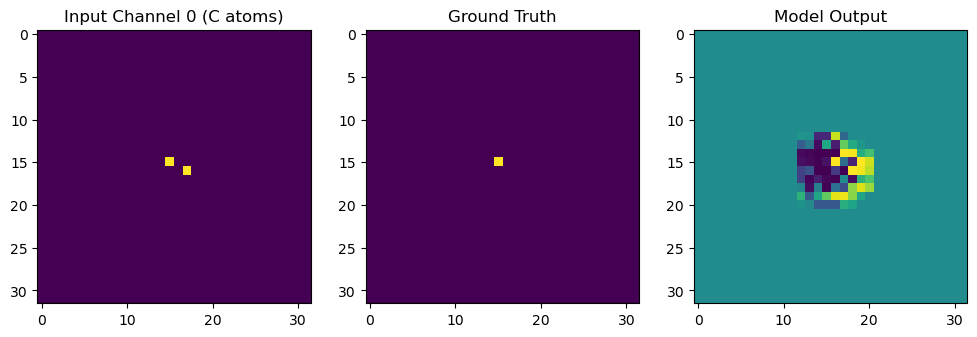

In [15]:
nonzero_voxels = torch.nonzero(Y[0, 0])  # get nonzero positions in label grid
slice_idx = nonzero_voxels[0][2] # grabs the z-index (slice number) of the first nonzero voxel

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(X[0, 0, slice_idx].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, 0, slice_idx].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(output[0, 0, slice_idx].detach().numpy())
axs[2].set_title("Model Output")
plt.show()


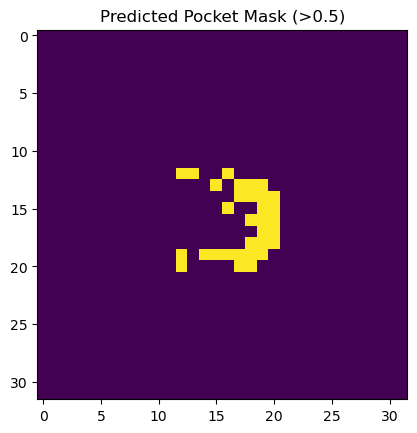

In [16]:
pred_mask = (output > 0.5).float()

plt.imshow(pred_mask[0, 0, slice_idx].detach().numpy())
plt.title("Predicted Pocket Mask (>0.5)")
plt.show()


In [17]:
def save_predicted_pocket_to_pdb(pred_grid, origin, voxel_size, pdb_filename, threshold=0.5):
    """
    Save predicted pocket voxels as pseudo-atoms in a PDB file.

    pred_grid: 3D numpy array or PyTorch tensor of shape (D, H, W)
    origin: 3D coordinate of voxel grid origin (numpy array or list)
    """
    if torch.is_tensor(pred_grid):
        pred_grid = pred_grid.squeeze().detach().cpu().numpy()

    with open(pdb_filename, 'w') as f:
        atom_index = 1
        for x in range(pred_grid.shape[0]):
            for y in range(pred_grid.shape[1]):
                for z in range(pred_grid.shape[2]):
                    if pred_grid[x, y, z] > threshold:
                        coord = origin + np.array([x, y, z]) * voxel_size
                        f.write(
                            f"HETATM{atom_index:5d}  X   UNK     1    "
                            f"{coord[0]:8.3f}{coord[1]:8.3f}{coord[2]:8.3f}  1.00  0.00           X\n"
                        )
                        atom_index += 1
        f.write("END\n")


In [18]:
# Fake prediction = use label grid as if it were model output
predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_dummy_pocket.pdb",
    threshold=0.5
)


In [19]:
import torch
'''
# Step 1: Voxelize the protein and get the origin
protein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)

# Step 2: Generate the label grid using the same origin
label_grid = generate_label_grid("1a1e_pocket.pdb", origin)

# Step 3: Convert to PyTorch tensors and format for CNN input
# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)

X = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)
Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

# Step 4: Run the model (make sure the model is already defined and on the right device)
model = Pocket3DCNN(in_channels=4)
output = model(X)

# Step 5: Compute loss (e.g., for one example)
criterion = torch.nn.BCELoss()
loss = criterion(output, Y)
print(f"Loss: {loss.item():.4f}")

predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_1a1e_pocket.pdb",
    threshold=0.5
)
'''

'\n# Step 1: Voxelize the protein and get the origin\nprotein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)\n\n# Step 2: Generate the label grid using the same origin\nlabel_grid = generate_label_grid("1a1e_pocket.pdb", origin)\n\n# Step 3: Convert to PyTorch tensors and format for CNN input\n# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)\n\nX = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)\nY = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)\n\n# Step 4: Run the model (make sure the model is already defined and on the right device)\nmodel = Pocket3DCNN(in_channels=4)\noutput = model(X)\n\n# Step 5: Compute loss (e.g., for one example)\ncriterion = torch.nn.BCELoss()\nloss = criterion(output, Y)\nprint(f"Loss: {loss.item():.4f}")\n\npredicted_voxels = torch.tensor(label_grid).float()\n\n# Save prediction to PDB\nsave_predicted_pocket_to_pdb(\n    pred_grid=

In [20]:
'''
# Voxelize protein
protein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)

# Generate label grid
label_grid = generate_label_grid("1a1e_pocket.pdb", origin)

# Fake prediction = use label grid as if it were model output
predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_1a1e_pocket.pdb",
    threshold=0.5
)
'''

'\n# Voxelize protein\nprotein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)\n\n# Generate label grid\nlabel_grid = generate_label_grid("1a1e_pocket.pdb", origin)\n\n# Fake prediction = use label grid as if it were model output\npredicted_voxels = torch.tensor(label_grid).float()\n\n# Save prediction to PDB\nsave_predicted_pocket_to_pdb(\n    pred_grid=predicted_voxels,\n    origin=origin,\n    voxel_size=1.0,\n    pdb_filename="predicted_1a1e_pocket.pdb",\n    threshold=0.5\n)\n'

In [21]:
import os
import glob

def collect_pdb_pairs(dataset_root):
    protein_paths = []
    pocket_paths = []

    # Loop through all subdirectories (each one is a complex)
    for pdb_dir in sorted(os.listdir(dataset_root)):
        full_path = os.path.join(dataset_root, pdb_dir)
        if not os.path.isdir(full_path):
            continue  # skip files

        # Find *_protein.pdb and *_pocket.pdb
        protein_pdb = glob.glob(os.path.join(full_path, "*_protein.pdb"))
        pocket_pdb = glob.glob(os.path.join(full_path, "*_pocket.pdb"))

        # Basic sanity check
        if protein_pdb and pocket_pdb:
            protein_paths.append(protein_pdb[0])
            pocket_paths.append(pocket_pdb[0])

    return protein_paths, pocket_paths


In [22]:
#!pip install gdown
#!gdown 1mtU0n_-ejTE9yA_G7iuOQJ4BCs9FVUhs --output dataset.zip


In [23]:
#!unzip dataset.zip

In [24]:
dataset_root = "refined-set"  # e.g., "./data" or wherever your folders are
protein_paths, pocket_paths = collect_pdb_pairs(dataset_root)

print(f"Found {len(protein_paths)} protein-pocket pairs.")

# Now feed into your dataset
from torch.utils.data import DataLoader

dataset = PocketGridDataset(protein_paths, pocket_paths, grid_size=32, voxel_size=1.0)
loader = DataLoader(dataset, batch_size=2, shuffle=True)


Found 5316 protein-pocket pairs.


In [25]:
X, Y = dataset[0]
print("Input shape:", X.shape)  # should be (channels, 32, 32, 32)
print("Label shape:", Y.shape)  # should be (1, 32, 32, 32)
print("Pocket voxels in label:", Y.sum().item())


Input shape: torch.Size([4, 32, 32, 32])
Label shape: torch.Size([1, 32, 32, 32])
Pocket voxels in label: 367.0


In [26]:
model = Pocket3DCNN(in_channels=4)

# Grab one sample from the dataset
X, Y = dataset[0]

# Make sure it's shaped for the model: (1, C, D, H, W)
X_input = X.unsqueeze(0)  # add batch dimension: (1, 4, 32, 32, 32)

# Run the model
model.eval()
with torch.no_grad():
    preds = model(X_input)[0]  # remove batch dimension again → shape: (1, 32, 32, 32)

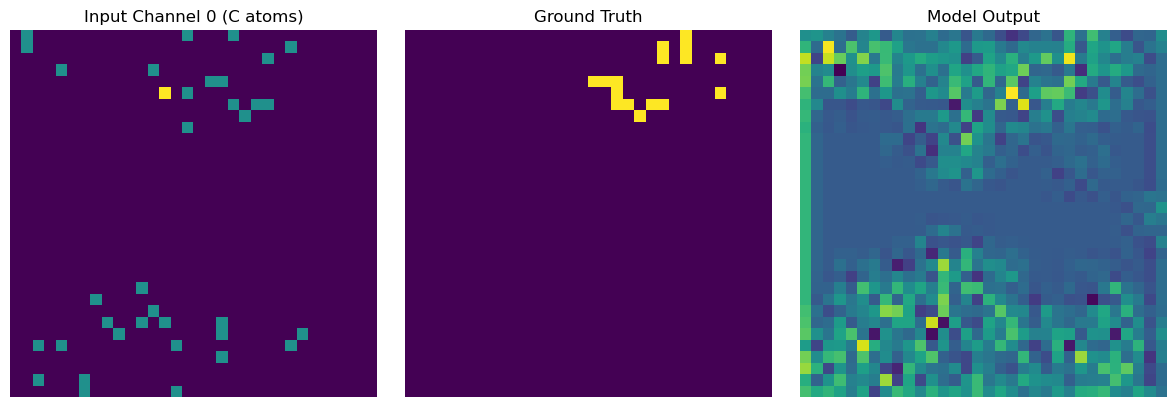

In [27]:
import matplotlib.pyplot as plt

# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(X[0, slice_idx, :, :].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, slice_idx, :, :].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(preds[0, slice_idx, :, :].detach().numpy())
axs[2].set_title("Model Output")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [28]:
print("Using GPU?", torch.cuda.is_available())


Using GPU? True


In [29]:
from sklearn.metrics import recall_score, accuracy_score
import torch

def accuracy(preds, labels):
    preds = preds > 0.5  # For binary segmentation (adjust threshold if needed)
    correct = (preds == labels).sum().item()
    total = labels.numel()
    return correct / total

import torch.nn as nn

def dice_loss(preds, target, smooth=1e-8):
        # Apply sigmoid for Dice computation
    probs = torch.sigmoid(preds)

    target = target.to(preds.device)

    # Dice Loss
    intersection = (probs * target).sum()
    dice_score = (2. * intersection + smooth) / (probs.sum() + target.sum() + smooth)
    loss = 1 - dice_score

    return loss

In [30]:
import torch

# Saving checkpoint
def save_checkpoint(model, optimizer, epoch, loss, filename='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch}.")

In [31]:
import torch
from sklearn.metrics import recall_score

def precision(preds, targets, threshold=0.6, epsilon=1e-8):
    # If preds are logits, apply sigmoid
    if preds.dtype != torch.bool:
        preds = torch.sigmoid(preds)

    preds_bin = (preds > threshold).float()
    targets = targets.float()

    true_positives = (preds_bin * targets).sum()
    predicted_positives = preds_bin.sum()

    return (true_positives / (predicted_positives + epsilon)).item()

def recall(preds, labels, threshold=0.6):  # Use the threshold arg here
    if preds.dtype != torch.bool:
        preds = torch.sigmoid(preds)
    preds_bin = (preds > threshold).float()
    
    # Flatten for sklearn
    preds_flat = preds_bin.view(-1).cpu().numpy()
    labels_flat = labels.view(-1).cpu().numpy()
    
    return recall_score(labels_flat, preds_flat)


def f1_score(prec, rec, eps=1e-8):
    return 2 * (prec * rec) / (prec + rec + eps)


In [32]:
thresholds = np.linspace(0.1, 0.9, 9)

for t in thresholds:
    prec = precision(preds, Y, threshold=t)
    rec = recall(preds, Y, threshold=t)  # now using correct threshold
    f1 = f1_score(prec, rec)
    print(f"Threshold: {t:.1f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}")


Threshold: 0.1 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.2 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.3 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.4 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.5 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.6 | Precision: 0.0112 | Recall: 1.0000 | F1: 0.0222
Threshold: 0.7 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.8 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000
Threshold: 0.9 | Precision: 0.0000 | Recall: 0.0000 | F1: 0.0000


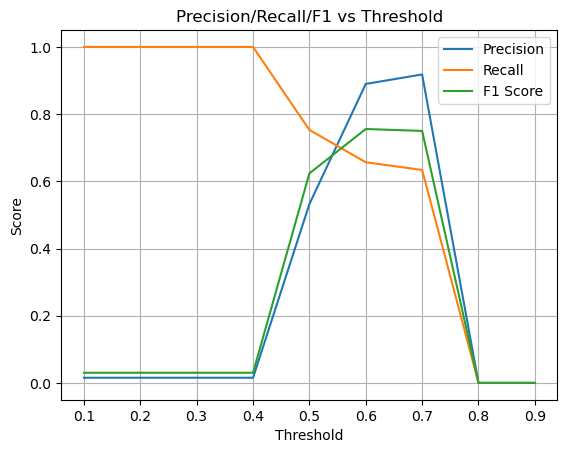

In [33]:
import matplotlib.pyplot as plt

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
precisions = [0.0154, 0.0154, 0.0154, 0.0154, 0.5323, 0.8898, 0.9181, 0.0, 0.0]
recalls =    [1.0000, 1.0000, 1.0000, 1.0000, 0.7530, 0.6567, 0.6339, 0.0, 0.0]
f1_scores =  [0.0303, 0.0303, 0.0303, 0.0303, 0.6237, 0.7557, 0.7500, 0.0, 0.0]

plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision/Recall/F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [34]:
import torch.nn.functional as F

def combined_dice_bce_loss(preds, targets):
    # Apply sigmoid for Dice computation
    probs = torch.sigmoid(preds)
    
    # Dice Loss
    dice = dice_loss(preds, targets)

    # BCE Loss (with logits = raw outputs from model)
    bce_loss = F.binary_cross_entropy_with_logits(preds, targets)

    # Combine both (equal weights)
    return 0.5 * dice + 0.5 * bce_loss


In [35]:

'''import os
import numpy as np
import torch

os.makedirs("voxels", exist_ok=True)

for i, (X, Y) in enumerate(dataset):  # your original dataset class
    np.save(f"voxels/X_{i}.npy", X.numpy())
    np.save(f"voxels/Y_{i}.npy", Y.numpy())
'''

'import os\nimport numpy as np\nimport torch\n\nos.makedirs("voxels", exist_ok=True)\n\nfor i, (X, Y) in enumerate(dataset):  # your original dataset class\n    np.save(f"voxels/X_{i}.npy", X.numpy())\n    np.save(f"voxels/Y_{i}.npy", Y.numpy())\n'

In [36]:
class VoxelNPYDataset(torch.utils.data.Dataset):
    def __init__(self, voxel_dir, total_samples):
        self.voxel_dir = voxel_dir
        self.total_samples = total_samples

    def __len__(self):
        return self.total_samples

    def __getitem__(self, idx):
        X_path = os.path.join(self.voxel_dir, f"X_{idx}.npy")
        Y_path = os.path.join(self.voxel_dir, f"Y_{idx}.npy")
        
        X = torch.tensor(np.load(X_path)).float()
        Y = torch.tensor(np.load(Y_path)).float()
        
        return X, Y


In [37]:
dataset = VoxelNPYDataset("voxels", total_samples=5305)


In [38]:
# Loading checkpoint
def load_checkpoint(model, optimizer, filename='checkpoint.pth'):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    print(f"Checkpoint loaded from epoch {epoch}.")
    return model, optimizer, epoch, loss


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [40]:
torch.cuda.is_available()

True

In [41]:
model = Pocket3DCNN(in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [42]:
import torch
from torch.utils.data import DataLoader, random_split
import time

# === Dataset Splitting (80/10/10) ===
num_total = len(dataset)
num_test = int(0.10 * num_total)
num_val = int(0.10 * num_total)
num_train = num_total - num_val - num_test

train_set, val_set, test_set = random_split(
    dataset,
    [num_train, num_val, num_test],
    generator=torch.Generator().manual_seed(42)
)


In [57]:

# === Setup ===
model = Pocket3DCNN(in_channels=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

val_loader   = DataLoader(val_set, batch_size=2, shuffle=False)
train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=2, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 20
'''
# === Metric Tracking ===
train_losses, val_losses = [], []
train_accuracies, train_recalls, train_pres, train_f1 = [], [], [], []
val_accuracies, val_recalls, val_pres, val_f1 = [], [], [], []

# === Checkpoint Handling ===
start_epoch = 0
best_val_loss = float('inf')'''


"\n# === Metric Tracking ===\ntrain_losses, val_losses = [], []\ntrain_accuracies, train_recalls, train_pres, train_f1 = [], [], [], []\nval_accuracies, val_recalls, val_pres, val_f1 = [], [], [], []\n\n# === Checkpoint Handling ===\nstart_epoch = 0\nbest_val_loss = float('inf')"

In [58]:
try:
    model, optimizer, start_epoch, _ = load_checkpoint(model, optimizer, 'checkpoint2.pth')
    print(f"Resuming from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    print("No checkpoint found, starting from scratch.")

# === Training Loop ===
for epoch in range(start_epoch, num_epochs):
    epoch_start = time.time()
    model.train()
    total_loss = correct_train = total_train = 0
    total_train_recall = total_pres = total_f1 = 0

    for i, (X, Y) in enumerate(train_loader):
        batch_start = time.time()

        X, Y = X.to(device), Y.to(device)
        preds = model(X)
        loss = combined_dice_bce_loss(preds, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        acc = accuracy(preds, Y)
        rec = recall(preds, Y)
        pres = precision(preds, Y)
        f1 = f1_score(pres, rec)

        correct_train += acc
        total_train += 1
        total_train_recall += rec
        total_pres += pres
        total_f1 += f1

        batch_time = time.time() - batch_start
        if i % 100 == 0:
            print(f"Batch {i+1}/{len(train_loader)} | Loss: {loss.item():.4f} | Time: {batch_time:.2f}")
    
    epoch_time = time.time() - epoch_start

    # Average training metrics
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = correct_train / total_train
    avg_recall = total_train_recall / total_train
    avg_pres = total_pres / total_train
    avg_f1 = total_f1 / total_train

    train_losses.append(avg_loss)
    train_accuracies.append(avg_accuracy)
    train_recalls.append(avg_recall)
    train_pres.append(avg_pres)
    train_f1.append(avg_f1)

    print(f"Epoch {epoch+1} Train | Loss: {avg_loss:.4f}, Acc: {avg_accuracy:.4f}, Recall: {avg_recall:.4f}, Precision: {avg_pres:.4f}, F1: {avg_f1:.4f}")

    # === Validation ===
    model.eval()
    val_loss = correct_val = total_val = total_val_recall = total_val_pres = total_val_f1 = 0

    with torch.no_grad():
        for X_val, Y_val in val_loader:
            X_val, Y_val = X_val.to(device), Y_val.to(device)
            preds_val = model(X_val)
            loss_val = combined_dice_bce_loss(preds_val, Y_val)
            val_loss += loss_val.item()

            acc_val = accuracy(preds_val, Y_val)
            rec_val = recall(preds_val, Y_val)
            pres_val = precision(preds_val, Y_val)
            f1_val = f1_score(pres_val, rec_val)

            correct_val += acc_val
            total_val += 1
            total_val_recall += rec_val
            total_val_pres += pres_val
            total_val_f1 += f1_val

    # Average validation metrics
    avg_val_loss = val_loss / len(val_loader)
    avg_val_accuracy = correct_val / total_val
    avg_val_recall = total_val_recall / total_val
    avg_val_pres = total_val_pres / total_val
    avg_val_f1 = total_val_f1 / total_val

    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)
    val_recalls.append(avg_val_recall)
    val_f1.append(avg_val_f1)
    val_pres.append(avg_val_pres)

    print(f"Epoch {epoch+1} Val   | Loss: {avg_val_loss:.4f}, Acc: {avg_val_accuracy:.4f}, Recall: {avg_val_recall:.4f}, Precision: {avg_val_pres:.4f}, F1: {avg_val_f1:.4f}")

    save_checkpoint(model, optimizer, epoch+1, avg_loss, filename="checkpoint2.pth")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model2.pt')
        print("Best model saved.")

# === Final Test Evaluation ==='''

print("\n🔍 Evaluating on Test Set...")
model.load_state_dict(torch.load('best_model2.pt'))
model.eval()

test_loss = correct_test = total_test = total_test_recall = total_test_pres = total_test_f1 = 0
model = model.to(device)
with torch.no_grad():
    for X_test, Y_test in test_loader:
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        preds_test = model(X_test)
        loss_test = combined_dice_bce_loss(preds_test, Y_test)
        test_loss += loss_test.item()

        acc_test = accuracy(preds_test, Y_test)
        rec_test = recall(preds_test, Y_test)
        pres_test = precision(preds_test, Y_test)
        f1_test = f1_score(pres_test, rec_test)

        correct_test += acc_test
        total_test += 1
        total_test_recall += rec_test
        total_test_pres += pres_test
        total_test_f1 += f1_test

print(f"\n📊 Final Test Results:")
print(f"Loss:      {test_loss / len(test_loader):.4f}")
print(f"Accuracy:  {correct_test / total_test:.4f}")
print(f"Recall:    {total_test_recall / total_test:.4f}")
print(f"Precision: {total_test_pres / total_test:.4f}")
print(f"F1 Score:  {total_test_f1 / total_test:.4f}")


/tmp/ipykernel_4840/3675328705.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 15.
Resuming from epoch 15
Batch 1/2123 | Loss: 0.8359 | Time: 0.04


/home/ivon/miniconda3/envs/bioenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 101/2123 | Loss: 0.8299 | Time: 0.03
Batch 201/2123 | Loss: 0.8340 | Time: 0.03
Batch 301/2123 | Loss: 0.8359 | Time: 0.03
Batch 401/2123 | Loss: 0.8363 | Time: 0.03
Batch 501/2123 | Loss: 0.8336 | Time: 0.03
Batch 601/2123 | Loss: 0.8338 | Time: 0.03
Batch 701/2123 | Loss: 0.8396 | Time: 0.03
Batch 801/2123 | Loss: 0.8352 | Time: 0.04


/home/ivon/miniconda3/envs/bioenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 901/2123 | Loss: 0.8391 | Time: 0.03
Batch 1001/2123 | Loss: 0.8316 | Time: 0.04
Batch 1101/2123 | Loss: 0.8307 | Time: 0.03
Batch 1201/2123 | Loss: 0.8296 | Time: 0.04
Batch 1301/2123 | Loss: 0.8339 | Time: 0.04
Batch 1401/2123 | Loss: 0.8255 | Time: 0.03
Batch 1501/2123 | Loss: 0.8426 | Time: 0.03
Batch 1601/2123 | Loss: 0.8327 | Time: 0.03
Batch 1701/2123 | Loss: 0.8400 | Time: 0.04
Batch 1801/2123 | Loss: 0.8364 | Time: 0.03
Batch 1901/2123 | Loss: 0.8357 | Time: 0.03
Batch 2001/2123 | Loss: 0.8346 | Time: 0.03
Batch 2101/2123 | Loss: 0.8304 | Time: 0.03
Epoch 16 Train | Loss: 0.8345, Acc: 0.9893, Recall: 0.2787, Precision: 0.4968, F1: 0.3483
Epoch 16 Val   | Loss: 0.8345, Acc: 0.9875, Recall: 0.2923, Precision: 0.4141, F1: 0.3364
Checkpoint saved at epoch 16.
Batch 1/2123 | Loss: 0.8399 | Time: 0.05
Batch 101/2123 | Loss: 0.8422 | Time: 0.03
Batch 201/2123 | Loss: 0.8284 | Time: 0.03
Batch 301/2123 | Loss: 0.8385 | Time: 0.03
Batch 401/2123 | Loss: 0.8320 | Time: 0.03
Batch 

/home/ivon/miniconda3/envs/bioenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 1901/2123 | Loss: 0.8365 | Time: 0.03
Batch 2001/2123 | Loss: 0.8355 | Time: 0.03
Batch 2101/2123 | Loss: 0.8329 | Time: 0.03
Epoch 17 Train | Loss: 0.8345, Acc: 0.9893, Recall: 0.2858, Precision: 0.5049, F1: 0.3562
Epoch 17 Val   | Loss: 0.8345, Acc: 0.9872, Recall: 0.3119, Precision: 0.4031, F1: 0.3452
Checkpoint saved at epoch 17.
Batch 1/2123 | Loss: 0.8324 | Time: 0.03
Batch 101/2123 | Loss: 0.8325 | Time: 0.03
Batch 201/2123 | Loss: 0.8311 | Time: 0.03
Batch 301/2123 | Loss: 0.8345 | Time: 0.03
Batch 401/2123 | Loss: 0.8347 | Time: 0.03
Batch 501/2123 | Loss: 0.8320 | Time: 0.03
Batch 601/2123 | Loss: 0.8364 | Time: 0.03
Batch 701/2123 | Loss: 0.8371 | Time: 0.03
Batch 801/2123 | Loss: 0.8356 | Time: 0.03
Batch 901/2123 | Loss: 0.8339 | Time: 0.03
Batch 1001/2123 | Loss: 0.8274 | Time: 0.03
Batch 1101/2123 | Loss: 0.8368 | Time: 0.03
Batch 1201/2123 | Loss: 0.8361 | Time: 0.03
Batch 1301/2123 | Loss: 0.8423 | Time: 0.03
Batch 1401/2123 | Loss: 0.8366 | Time: 0.03
Batch 1501

/home/ivon/miniconda3/envs/bioenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 101/2123 | Loss: 0.8323 | Time: 0.03
Batch 201/2123 | Loss: 0.8339 | Time: 0.03
Batch 301/2123 | Loss: 0.8346 | Time: 0.03
Batch 401/2123 | Loss: 0.8314 | Time: 0.03
Batch 501/2123 | Loss: 0.8342 | Time: 0.03
Batch 601/2123 | Loss: 0.8285 | Time: 0.03
Batch 701/2123 | Loss: 0.8367 | Time: 0.03
Batch 801/2123 | Loss: 0.8319 | Time: 0.03
Batch 901/2123 | Loss: 0.8306 | Time: 0.03
Batch 1001/2123 | Loss: 0.8353 | Time: 0.03
Batch 1101/2123 | Loss: 0.8329 | Time: 0.03
Batch 1201/2123 | Loss: 0.8270 | Time: 0.03
Batch 1301/2123 | Loss: 0.8316 | Time: 0.03
Batch 1401/2123 | Loss: 0.8321 | Time: 0.03
Batch 1501/2123 | Loss: 0.8320 | Time: 0.03
Batch 1601/2123 | Loss: 0.8323 | Time: 0.03
Batch 1701/2123 | Loss: 0.8405 | Time: 0.03
Batch 1801/2123 | Loss: 0.8371 | Time: 0.03
Batch 1901/2123 | Loss: 0.8350 | Time: 0.03
Batch 2001/2123 | Loss: 0.8405 | Time: 0.03
Batch 2101/2123 | Loss: 0.8367 | Time: 0.03
Epoch 19 Train | Loss: 0.8344, Acc: 0.9895, Recall: 0.2949, Precision: 0.5143, F1: 0.

/home/ivon/miniconda3/envs/bioenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Batch 2001/2123 | Loss: 0.8198 | Time: 0.03
Batch 2101/2123 | Loss: 0.8362 | Time: 0.03
Epoch 20 Train | Loss: 0.8343, Acc: 0.9895, Recall: 0.2978, Precision: 0.5173, F1: 0.3700
Epoch 20 Val   | Loss: 0.8344, Acc: 0.9885, Recall: 0.2253, Precision: 0.4584, F1: 0.2960
Checkpoint saved at epoch 20.

🔍 Evaluating on Test Set...


/tmp/ipykernel_4840/1968151035.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model2.pt'))



📊 Final Test Results:
Loss:      0.8350
Accuracy:  0.9885
Recall:    0.2228
Precision: 0.4219
F1 Score:  0.2836


In [45]:
num_layers = sum(1 for _ in model.modules())
print(f"Total layers (modules): {num_layers}")


Total layers (modules): 13


In [46]:
import torch

print("CUDA available:", torch.cuda.is_available())

if not torch.cuda.is_available():
    try:
        torch.empty(1).cuda()
    except Exception as e:
        print("Error when trying to move tensor to GPU:")
        print(e)


CUDA available: True


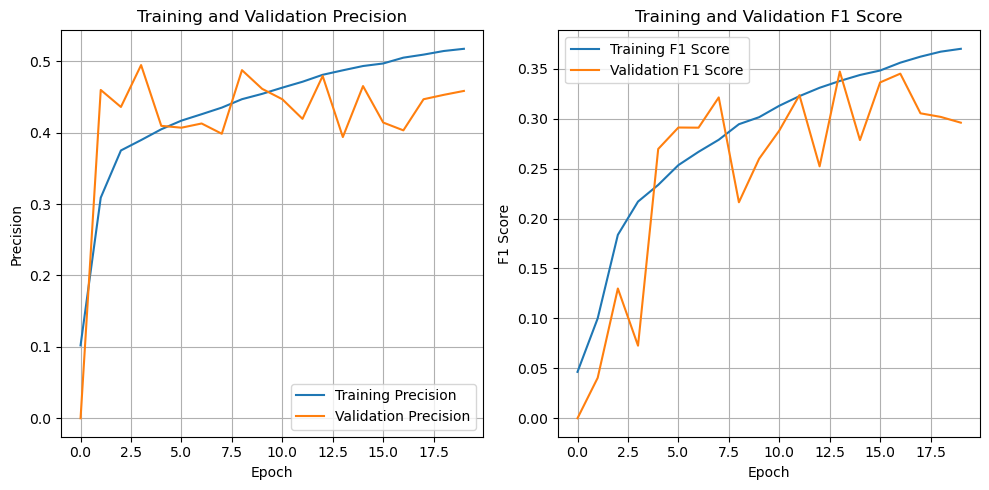

In [59]:
import matplotlib.pyplot as plt

# Plot training and validation Precision & F1 Score
plt.figure(figsize=(10, 5))

# Precision plot
plt.subplot(1, 2, 1)
plt.plot(train_pres, label='Training Precision')
plt.plot(val_pres, label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.grid(True)

# F1 Score plot
plt.subplot(1, 2, 2)
plt.plot(train_f1, label='Training F1 Score')
plt.plot(val_f1, label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [48]:
self.dropout = nn.Dropout(p=0.5)  # Or 0.3, 0.4 — tune this

# In forward pass
x = self.dropout(x)


NameError: name 'self' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Ensure model is in eval mode
model.eval()

with torch.no_grad():
    X_val, Y_val = next(iter(val_loader))  # just one batch
    X_val = X_val.to(device)
    Y_val = Y_val.to(device)

    y_pred = model(X_val)

    # Apply threshold
    y_pred_classes = (y_pred > 0.5).int().cpu().numpy()
    Y_val_np = Y_val.int().cpu().numpy()

    # Flatten for sklearn compatibility
    cm = confusion_matrix(Y_val_np.flatten(), y_pred_classes.flatten())
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


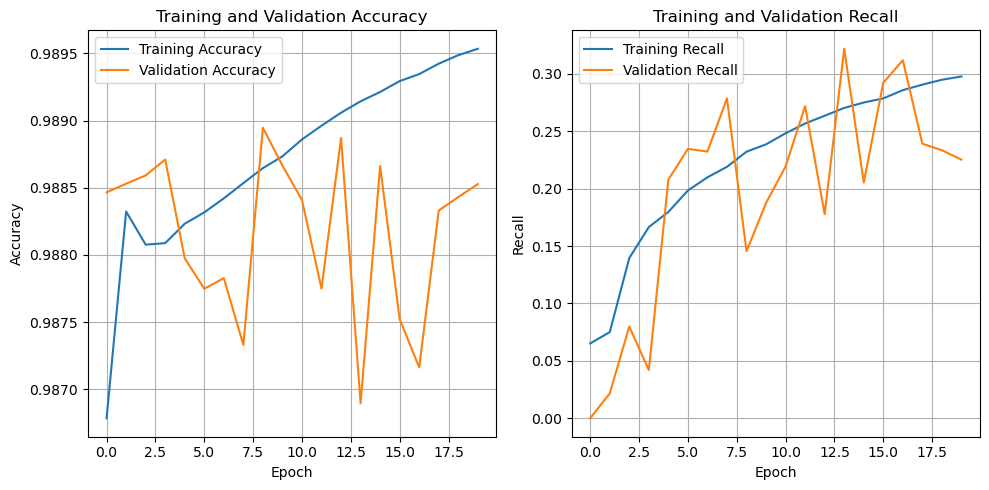

In [60]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Recall plot
plt.subplot(1, 2, 2)
plt.plot(train_recalls, label='Training Recall')
plt.plot(val_recalls, label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

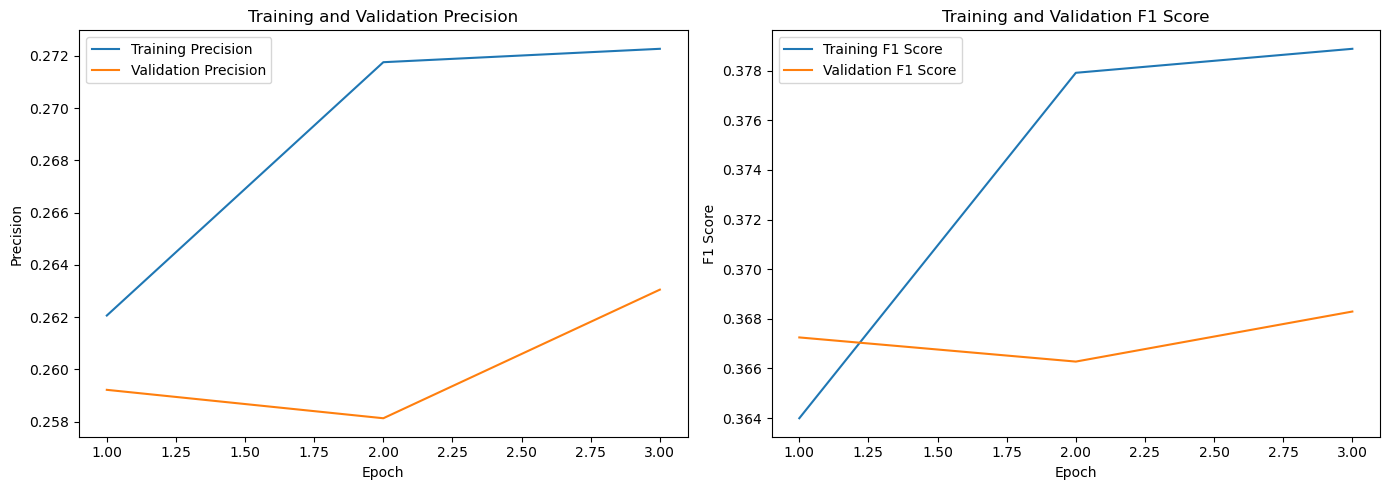

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_pres) + 1)

plt.figure(figsize=(14, 5))

# Precision plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_pres, label='Training Precision')
plt.plot(epochs, val_pres, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# F1 Score plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_f1, label='Training F1 Score')
plt.plot(epochs, val_f1, label='Validation F1 Score')
plt.title('Training and Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
metrics = [tf.keras.metrics.AUC(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

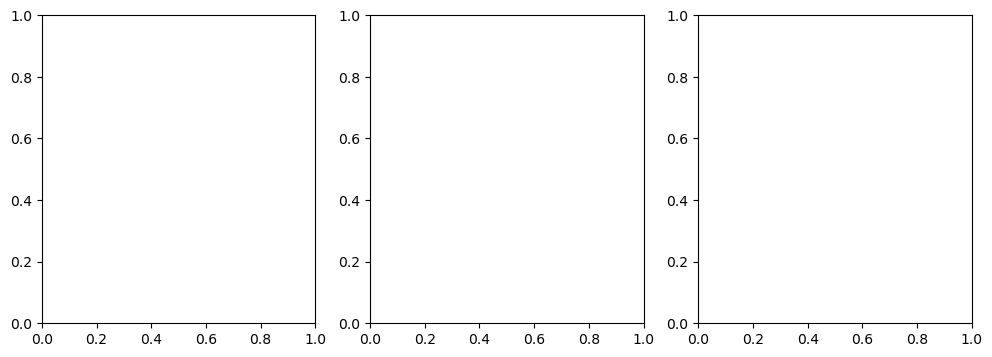

In [ ]:
# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(X[0, slice_idx, :, :].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, slice_idx, :, :].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(preds[0, slice_idx, :, :].detach().numpy())
axs[2].set_title("Model Output")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
# Get one sample from the train set

X_train, Y_train = train_set[0]
X_train_input = X_train.unsqueeze(0)

with torch.no_grad():
    train_pred = model(X_train_input)[0]

In [ ]:
# Get one sample from the val set
X_val, Y_val = val_set[0]
X_val_input = X_val.unsqueeze(0)

model.eval()
with torch.no_grad():
    val_pred = model(X_val_input)[0]

In [ ]:
# Get a slice where the ground truth has pocket voxels
nonzero_voxels = torch.nonzero(Y_val[0])  # shape: (N, 3)
if len(nonzero_voxels) > 0:
    slice_idx = nonzero_voxels[0][1].item()  # Y_val is (1, D, H, W)
else:
    print("⚠️ No pocket voxels found in this sample")
    slice_idx = 16  # fallback

print(f"Using slice {slice_idx}")


In [ ]:
axs[0].imshow(X_val[0, slice_idx, :, :].detach().numpy(), cmap='gray')
axs[1].imshow(Y_val[0, slice_idx, :, :].detach().numpy(), cmap='gray')
axs[2].imshow(val_pred[0, slice_idx, :, :].detach().numpy(), cmap='hot')


In [ ]:
# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
#slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center
slice_idx = 23
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Input (e.g., C atoms)
axs[0].imshow(X_val[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[0].set_title("Input Channel 0 (C atoms)")

# Ground Truth
axs[1].imshow(Y_val[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[1].set_title("Ground Truth Pocket")

# Model Prediction
axs[2].imshow(val_pred[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[2].set_title("Model Prediction")

for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


### Visualize some images

In [ ]:
# Show the first nine images and labels from the training set

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Data Augmentation

Since we have very little training data it makes sense to use some data augmentation for training. This will help preventing overfitting by introducing image sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
# Apply the data augmentation layers 9 times to the same image to see the results.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



 <font color='blue'> Can you think of other Data Augmentation techniques not mentioned here that might be useful?

_yourresponse_


## Initialize the ResNet model

We will use the [`Resnet50`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50) model, and set the `weights` parameter to `'imagenet'` to load the pre-trained weights on ImageNet.

When we print the arquitecture of the model, we see that the last layer is a fully connected (`Dense`) layer with 1000 output neurons as shown below:


   `predictions (Dense)             (None, 1000)`

In [ ]:
# Create the base model from the pre-trained model ResNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               weights='imagenet')

print(base_model.summary())

 <font color='blue'> Could you *briefly* explain what is the difference between those layers: Flatten, Dropout, Dense and MaxPooling?

_yourresponse_

 <font color='blue'> What is the input layer? its size? and the output layer? its size?

yourresponse

By specifying the `include_top=False` and `pooling='avg'` arguments, we load a network that doesn't include the classification layer at the top, which is ideal for transfer learning.



In [ ]:
# Create the base model from the pre-trained model ResNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')

print(base_model.summary())

Now the base model converts each 224x224x3 image into a 2048-d feature vector:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)


<font color='blue'> Why do we use a pre-trained model like ResNet50 instead of building one from scratch? In what situations would it be beneficial to use a pre-trained model in a clinical context?

_your response_

## Feature extraction

In this step, we will freeze the convolutional base created from the previous step to use it as a feature extractor. Then we will add a classification layer on top of it and train it using our training data.

In [ ]:
# prevent the weights in a given layer from being updated during training
base_model.trainable = False


In [ ]:
# add a classification layer
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


<font color='blue'> Which are the number of: epochs, batches and iterations?

_response_

### Train the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Plot the learning curves:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<font color='blue'> Look at the learning curves after training. How can you tell if the model is overfitting?

_your response_

## Fine tuning

In the feature extraction experiment, we were only training the last `Dense` layer on top of a ResNet50 base model. The weights of the pre-trained network were **not** updated during training.

Now we will train again our model but updating all the weights at training time.

In [ ]:
# Un-freeze the base model layers
base_model.trainable = True


In [ ]:
# add a classification layer
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [ ]:
history_ft = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Plot the learning curves and compare with the model trained with feature extraction:

In [ ]:
acc_ft = history_ft.history['accuracy']
val_acc_ft = history_ft.history['val_accuracy']
loss_ft = history_ft.history['loss']
val_loss_ft = history_ft.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy (Feat. extraction)')
plt.plot(val_acc, label='Validation Accuracy (Feat. extraction)')
plt.plot(acc_ft, label='Training Accuracy (Fine tuning)')
plt.plot(val_acc_ft, label='Validation Accuracy (Fine tuning)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss (Feat. extraction)')
plt.plot(val_loss, label='Validation Loss (Feat. extraction)')
plt.plot(loss_ft, label='Training Loss (Fine tuning)')
plt.plot(val_loss_ft, label='Validation Loss (Fine tuning)')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


We appreciate that while the final validation accuracy is quite similar in both models, the model trained with fine-tuning is more prone to overfitting. Which makes sense given the small size of the training dataset. Choosing one technique or another depends on many aspects, such as the model architecture, the size of the training data, and/or how similar are the source and target tasks.

<font color='blue'> Look at the learning curves after training and comparing. Is the same conclusion what you see on the plots?

### Additional References

- [Tensorflow transfer learning and fine-tuning guide](https://www.tensorflow.org/guide/keras/transfer_learning)
- [Transfer Learning page at the Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition.](https://cs231n.github.io/transfer-learning/)